In [36]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [37]:
from Waitbar import Waitbar
import os,sys
import pandas as pd
import gzip
import json

In [38]:
from pyndamics import *
from pyndamics.emcee import *

In [39]:
class NumpyAwareJSONEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            if obj.ndim == 1:
                return obj.tolist()
            else:
                return [self.default(obj[i]) for i in range(obj.shape[0])]
        return json.JSONEncoder.default(self, obj)

In [40]:
from pytz import timezone
from datetime import datetime,timedelta

def to_datetime(datestring,tzstr='utc'):
    created_at = datetime.strptime(datestring, '%a %b %d %H:%M:%S +0000 %Y')
    
    if 'utc' in tzstr.lower():
        tz = timezone('UTC')
        return tz.localize(created_at)

    if 'eastern' in tzstr.lower() or 'est'==tzstr.lower():
        tz = timezone('US/Eastern')
        return tz.localize(created_at)
    
def unix_time(dt):
    epoch = datetime.datetime.utcfromtimestamp(0)
    delta = dt - epoch
    return delta.total_seconds()
    

In [42]:
time_series='hours'
fname='../data/saved_twitter_data_jskaza_subseries'
with gzip.open(fname+'.json.gz','r') as fid:
    all_series=json.load(fid)


In [45]:
series=[x for x in all_series if x['series']=='time series %s' % time_series]
print "%d found." % len(series)

5 found.


In [47]:
mx,tags=zip(*sorted([ (max(x['y']),x['tag']) for x in series],reverse=True))
total_mx=mx[0]

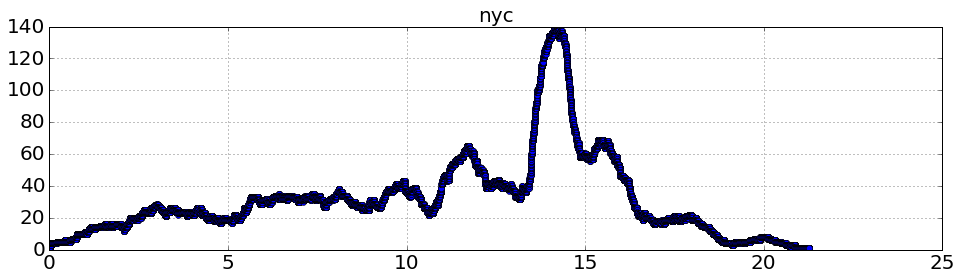

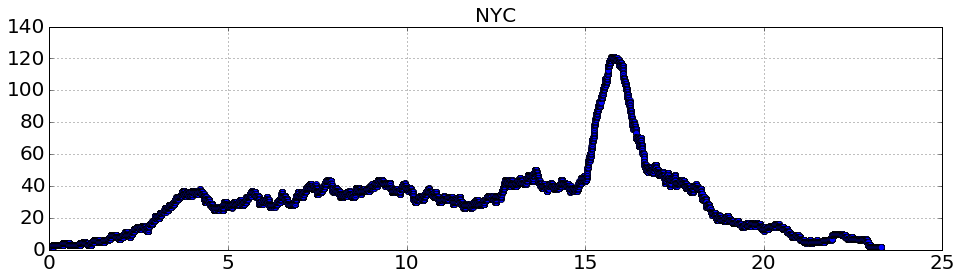

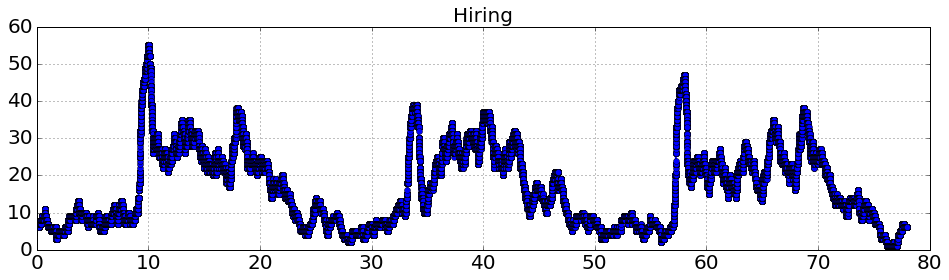

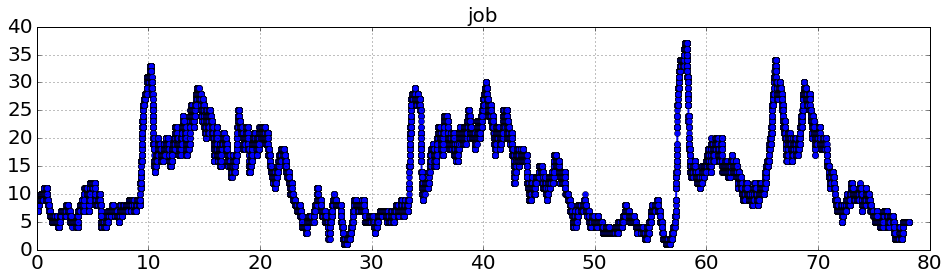

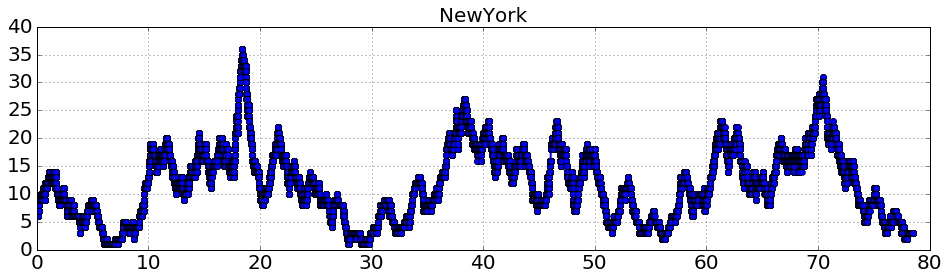

In [48]:
for tag in tags[:5]:
    data=[x for x in series if x['tag']==tag]
    #assert len(data)==1
    data=data[0]
    
    figure(figsize=(16,4))
    t,y=data['t'],data['y']
    plot(t,y,'-o')
    title(data['tag'])



In [50]:
results=[]
redo=[]

save_fname=fname+"mcmc"

for tag in tags:
    clf()
    
    stop=False
    count=0
    
    data=[x for x in series if x['tag']==tag]
    #assert len(data)==1
    data=data[0]

#     if not tag in redo and 'posteriors' in data:
#         print "Skipping ",tag,"...already done."
#         continue

    t,y=data['t'],data['y']

    timeit(reset=True)
    N=total_mx
    I0=0.01
    sim=Simulation()
    sim.add("N=initial_S+initial_I+initial_R")
    sim.add("S'=-beta*S/N*I",total_mx,plot=False)
    sim.add("I'=beta*S/N*I-gamma*I",.01,plot=False)  # start with a small infection
    sim.add("R'=gamma*I",0,plot=False)
    sim.params(beta=1/400.0,gamma=1/600.0)
    sim.add_data(t=t,I=y,plot=False)   # offset the time of the increase
    sim.run(0,max(t))

    model=MCMCModel(sim, 
                    beta=Uniform(0,100),
                    gamma=Uniform(0,100),
                    initial_S=Uniform(max(y),10000),
                    initial_I=Uniform(0.0001,max(y))
                    )

    model.verbose=False

    count=0
    while not stop:
        model.run_mcmc(500)

        # check for convergence
        samples=model.sampler.chain
        N=samples.shape[1]
        D=samples.shape[2]
        first=samples[:,:N/5,:].reshape((-1,D))
        second=samples[:,4*N/5:,:].reshape((-1,D))
        v1=first.mean(axis=0)
        v2=second.mean(axis=0)
        df=abs(v1-v2)/v2        

        print timeit()
        if all(df<0.01):
            print "Converged...",tag
            stop=True
        else:
            print "Repeat for convergence...",tag
            model.burn(0.75)
            model.set_initial_values('samples')

        count+=1
        if count>6:
            print "Max count reached for ",tag
            stop=True
        
    print "End.",timeit()

    t,y=data['t'],data['y']
    plot(t,y,'-o')
    title(data['tag'])

    percentiles=model.percentiles([2.5,50,97.5])
                                  
    posteriors={}
    for paramkey in model.keys:
        b1,b2=model.percentiles([.5,99.5])[paramkey]
        bins=linspace(b1,b2,500)
        i=model.index[paramkey]
        x,px=histogram(model.samples[:,i],bins=bins,plot=False)    
        posteriors[paramkey]={'x':x,'px':px}
    
    paramkey='Rep'
    beta=model.samples[:,model.index['beta']]
    gamma=model.samples[:,model.index['gamma']]
    S0=model.samples[:,model.index['initial_S']]
    I0=model.samples[:,model.index['initial_I']]
    N0=S0+I0
    RR=beta/gamma*S0/N0
    
    b1,b2=np.percentile(RR,[.5,99.5],axis=0)
    bins=linspace(b1,b2,500)
    x,px=histogram(RR,bins=bins,plot=False)    
    posteriors[paramkey]={'x':x,'px':px}    
    percentiles[paramkey]=np.percentile(RR,[2.5,50,97.5],axis=0)
    
    
    data.update({
            'percentiles':percentiles,
            'posteriors':posteriors,
           })
    
    
    traces=[]
    sim.noplots=True  # turn off the simulation plots
    for i in range(5000):
        model.draw()
        sim.run(0,max(t))
        plot(sim.t,sim.I,'g-',alpha=.05)
        traces.append(sim.I)        
    sim.noplots=False  # gotta love a double-negative    
    traces=array(traces)
    lower,middle,upper=np.percentile(traces, [2.5,50,97.5],axis=0)
    plot(sim.t,lower,'c-')
    plot(sim.t,upper,'y-')

    data.update({'lower sim':lower,'upper sim':upper,
           })
        
    figname='sir'+" "+tag+" "+data['series']+".png"
    print figname
    gcf().savefig('../figs/%s' % figname)
    
    results.append(data)
    
    
    with gzip.open(save_fname+".json.gz",'w') as fid:
        json.dump(results,fid,cls=NumpyAwareJSONEncoder)    
    


3 m, 54.27 s
Repeat for convergence... nyc
8 m, 17.03 s
Repeat for convergence... nyc
12 m, 30.71 s
Converged... nyc
End. 12 m, 30.71 s
sir nyc time series hours.png
3 m, 54.88 s
Repeat for convergence... NYC
8 m, 34.37 s
Repeat for convergence... NYC
13 m, 8.03 s
Converged... NYC
End. 13 m, 8.03 s
sir NYC time series hours.png
13 m, 34.49 s
Repeat for convergence... Hiring
27 m, 27.45 s
Repeat for convergence... Hiring
41 m, 25.67 s
Repeat for convergence... Hiring
55 m, 53.95 s
Repeat for convergence... Hiring
1 h, 10 m, 18.27 s
Repeat for convergence... Hiring
1 h, 24 m, 28.02 s
Repeat for convergence... Hiring
5 h, 21 m, 16.43 s
Repeat for convergence... Hiring
Max count reached for  Hiring
End. 5 h, 21 m, 16.43 s
sir Hiring time series hours.png
13 m, 34.31 s
Repeat for convergence... job
28 m, 5.55 s
Repeat for convergence... job
42 m, 58.23 s
Repeat for convergence... job
57 m, 59.25 s
Repeat for convergence... job
1 h, 12 m, 36.02 s
Repeat for convergence... job
1 h, 26 m, 53.5

Traceback (most recent call last):
  File "/Users/bblais/anaconda/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/bblais/anaconda/lib/python2.7/site-packages/pyndamics/emcee/pemcee.py", line 393, in __call__
    return self.lnprob(theta)
  File "/Users/bblais/anaconda/lib/python2.7/site-packages/pyndamics/emcee/pemcee.py", line 386, in lnprob
    lnl=self.lnlike(theta)
  File "/Users/bblais/anaconda/lib/python2.7/site-packages/pyndamics/emcee/pemcee.py", line 339, in lnlike
    y_fit=self.sim.interpolate(t,name)
  File "/Users/bblais/anaconda/lib/python2.7/site-packages/pyndamics/simulation.py", line 866, in interpolate
    simvals=interp(t,st,svals)
  File "/Users/bblais/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py", line 1663, in interp
    return compiled_interp(x, xp, fp, left, right)
KeyboardInterrupt


KeyboardInterrupt: 

## SIRI

In [ ]:
results=[]
redo=[]

save_fname=fname+"mcmc_siri"

for tag in tags:
    clf()
    
    stop=False
    count=0
    
    data=[x for x in series if x['tag']==tag]
    #assert len(data)==1
    data=data[0]

#     if not tag in redo and 'posteriors' in data:
#         print "Skipping ",tag,"...already done."
#         continue

    t,y=data['t'],data['y']

    timeit(reset=True)
    N=total_mx
    I0=0.01
    sim=Simulation()
    sim.add("N=initial_S+initial_I+initial_R")
    sim.add("S'=-beta*S/N*I",total_mx,plot=False)
    sim.add("I'=beta*S/N*I-nu*I*R/N",I0,plot=False)  # start with a small infection
    sim.add("R'=nu*I*R/N",1,plot=False)
    sim.params(beta=1/400.0,nu=1/600.0)
    sim.add_data(t=t,I=y,plot=False)   # offset the time of the increase
    sim.run(0,max(t))

            
    model=MCMCModel(sim, 
                    beta=Uniform(0,100),
                    nu=Uniform(0,2000),
                    initial_S=Uniform(max(y),10000),
                    initial_I=Uniform(0.0001,max(y))
                    )

    model.verbose=False

    count=0
    while not stop:
        model.run_mcmc(500)

        # check for convergence
        samples=model.sampler.chain
        N=samples.shape[1]
        D=samples.shape[2]
        first=samples[:,:N/5,:].reshape((-1,D))
        second=samples[:,4*N/5:,:].reshape((-1,D))
        v1=first.mean(axis=0)
        v2=second.mean(axis=0)
        df=abs(v1-v2)/v2        

        print timeit()
        if all(df<0.01):
            print "Converged...",tag
            stop=True
        else:
            print "Repeat for convergence...",tag
            model.burn(0.75)
            model.set_initial_values('samples')

        count+=1
        if count>6:
            print "Max count reached for ",tag
            stop=True
        
    print "End.",timeit()

    t,y=data['t'],data['y']
    plot(t,y,'-o')
    title(data['tag'])

    percentiles=model.percentiles([2.5,50,97.5])
                                  
    posteriors={}
    for paramkey in model.keys:
        b1,b2=model.percentiles([.5,99.5])[paramkey]
        bins=linspace(b1,b2,500)
        i=model.index[paramkey]
        x,px=histogram(model.samples[:,i],bins=bins,plot=False)    
        posteriors[paramkey]={'x':x,'px':px}
    
    paramkey='Rep'
    beta=model.samples[:,model.index['beta']]
    gamma=model.samples[:,model.index['gamma']]
    S0=model.samples[:,model.index['initial_S']]
    I0=model.samples[:,model.index['initial_I']]
    N0=S0+I0
    RR=beta/gamma*S0/N0
    
    b1,b2=np.percentile(RR,[.5,99.5],axis=0)
    bins=linspace(b1,b2,500)
    x,px=histogram(RR,bins=bins,plot=False)    
    posteriors[paramkey]={'x':x,'px':px}    
    percentiles[paramkey]=np.percentile(RR,[2.5,50,97.5],axis=0)
    
    
    data.update({
            'percentiles':percentiles,
            'posteriors':posteriors,
           })
    
    
    traces=[]
    sim.noplots=True  # turn off the simulation plots
    for i in range(5000):
        model.draw()
        sim.run(0,max(t))
        plot(sim.t,sim.I,'g-',alpha=.05)
        traces.append(sim.I)        
    sim.noplots=False  # gotta love a double-negative    
    traces=array(traces)
    lower,middle,upper=np.percentile(traces, [2.5,50,97.5],axis=0)
    plot(sim.t,lower,'c-')
    plot(sim.t,upper,'y-')

    data.update({'lower sim':lower,'upper sim':upper,
           })
        
    figname='siri'+" "+tag+" "+data['series']+".png"
    print figname
    gcf().savefig('../figs/%s' % figname)
    
    results.append(data)
    
    
    with gzip.open(save_fname+".json.gz",'w') as fid:
        json.dump(results,fid,cls=NumpyAwareJSONEncoder)    
    
